In [1]:
#testing reaction network code
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, Kvaerno3, PIDController
import optax  
import pickle as pkl
#from reaction_nets import rxn_net
from functools import partial
import random
#from modified_reaction_nets import random_rxn_net
from reaction_nets import random_rxn_net
from rxn_nets_old import rxn_net

# Testing the triangle toplogy parameterization

In [19]:
jax.config.update("jax_enable_x64", True)

In [20]:
#generate flow profiles with params cal uses
rxn=rxn_net('triangle_a')
t_points = jnp.linspace(0.0, 10.0, 200)
all_features=jnp.linspace(-20, 20, 50)
initial_conditions = jnp.log(jnp.array([0.3, 0.4, 0.3]))

In [21]:
initial_params=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
true_params=-1*jnp.array([0, 0, 0, np.log(1), 0, np.log(10), np.log(1), 0, np.log(0.1), np.log(0.05), 0, np.log(4)])
file = open('data/train/triangle_a_training_data', 'rb')
data=pkl.load(file)
file.close()

In [22]:
optimized_params=data['optimized_params']

In [23]:
def profile(params, initial_conditions, all_features):
    solns=[]
    for feature in all_features:
        all_params=jnp.append(params, feature)
        solution = rxn.integrate(solver=Tsit5(), stepsize_controller=PIDController(0.5, 1), t_points=t_points, dt0=0.1, initial_conditions=initial_conditions, args=all_params, max_steps=10000)
        solns.append(solution.ys[-1].copy())
    return jnp.array(solns)

In [24]:
species_list = ['A', 'B', 'C']

In [25]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=initial_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
print(f'{E_A}-{B_AB}+{0.5*F_AB}+{0.5*F_AB_in}')
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

0.5-0.5+0.25+0.0
1.2840254166877414 1.2840254166877414 1.2840254166877414 0.7788007830714049 0.7788007830714049 0.7788007830714049


In [26]:
solns_initial= profile(initial_params, initial_conditions, all_features)

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/serenadebesai/miniconda3/envs/rxn_nets/lib/python3.13/site-packages/diffrax/_integrate.py", line 1502, in diffeqsolve
    sol = result.error_if(sol, jnp.invert(is_okay(result)))
equinox.EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


In [85]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=true_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)


1.0 1.0 0.05000000000000001 10.000000000000002 0.10000000000000002 4.0


In [86]:
solns_true=profile(true_params, initial_conditions, all_features)

In [87]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=optimized_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
print(f'{E_A}-{B_AB}+{0.5*F_AB}+{0.5*F_AB_in}')
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

0.010380762167212171-0.956231436383443+0.00847779702630139+0.0
0.39165541184885 0.4058907792399219 0.12421739585056382 1.3091706673547363 2.6611853250292286 0.7280896022305673


In [88]:
solns_opt=profile(optimized_params, initial_conditions, all_features)

In [ ]:
fig, axs=plt.subplots(3, figsize=(5, 10))
for species, profile in zip(
    
    , jnp.exp(solns_initial.T)):
    axs[0].plot(all_features, profile, label=f'{species}')
axs[0].plot(all_features, jnp.sum(jnp.exp(solns_initial.T), axis=0), label='total') 

for species, profile in zip(species_list, jnp.exp(solns_opt.T)):
    axs[1].plot(all_features, profile, label=f'{species}')

for species, profile in zip(species_list, jnp.exp(solns_true.T)):
    axs[2].plot(all_features, profile, label=f'{species}')
axs[2].plot(all_features, jnp.sum(jnp.exp(solns_true.T), axis=0), label='total') 

for i in range(3):
    axs[i].legend(bbox_to_anchor=[1.05, 1], loc='upper left')
    axs[i].set_xlabel(r'$F_a$')
    axs[i].set_ylabel(r'$\pi_i$')
    axs[i].set_xlim(-10, 15)

axs[0].set_title('Initial params')
axs[1].set_title('optimized params')
axs[2].set_title('True params')

fig.tight_layout()

# Generating bimodal profiles to sample training data from 

In [28]:
#sample from a mixture of two gaussians
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [29]:
jax.config.update("jax_enable_x64", True)

In [28]:
def plot_gaussian_mixture(x, mean1, var1, mean2, var2, weights):
    weight1, weight2=weights
    gaussian1 = norm.pdf(x, mean1, np.sqrt(var1))
    gaussian2 = norm.pdf(x, mean2, np.sqrt(var2))

    # Mixture
    mixture = weight1 * gaussian1 + weight2 * gaussian2

    return mixture

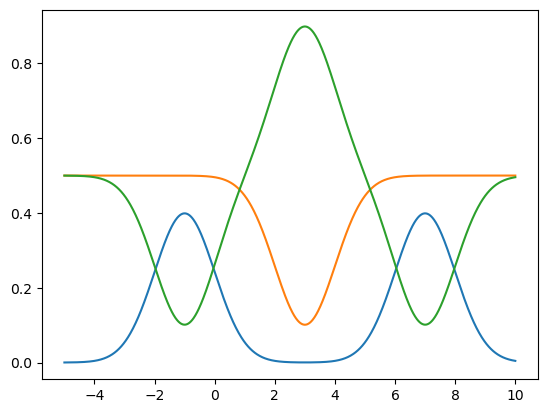

In [35]:
x=np.linspace(-5, 10, 1000)
weights=np.array([0.5, 0.5])
mean1, mean2, var1, var2=-1, 7, 1, 1
mixture_profile= 2*plot_gaussian_mixture(x, mean1, var1, mean2, var2, weights)
plt.plot(x, mixture_profile)
plt.plot(x, -norm.pdf(x, 3, np.sqrt(1))+0.5)
plt.plot(x, 1-(-norm.pdf(x, 3, np.sqrt(1))+0.5)-mixture_profile)

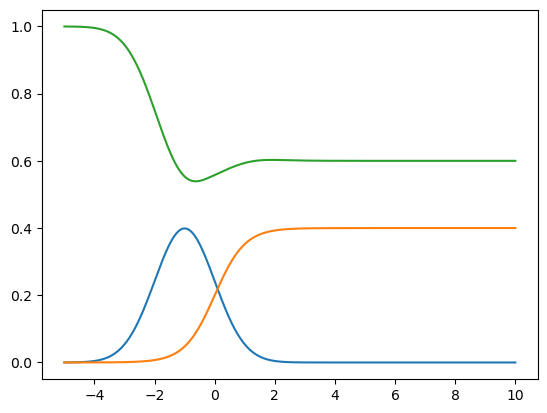

In [34]:
x=np.linspace(-5, 10, 1000)
mean1, var1=-1, 1
plt.plot(x, norm.pdf(x, mean1, np.sqrt(var1)))
plt.plot(x, 0.2*(1+np.tanh(x)))
plt.plot(x, 1-norm.pdf(x, mean1, np.sqrt(var1))-0.2*(1+np.tanh(x)))

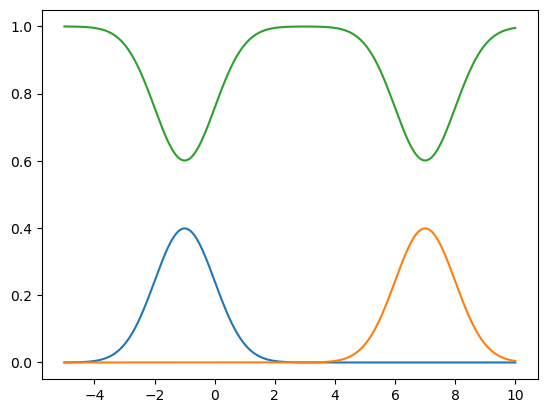

In [36]:
plt.plot(x, norm.pdf(x, mean1, np.sqrt(var1)))
plt.plot(x, norm.pdf(x, mean2, np.sqrt(var2)))
plt.plot(x, 1-norm.pdf(x, mean1, np.sqrt(var1))-norm.pdf(x, mean2, np.sqrt(var2)))

# Testing generation of random networks single order networks

In [2]:
n=3
n_input_edges=1
adjacency_matrix = jnp.array(np.random.choice([-1, 0, 1], size=(n, n))) #0 means no edge, -1 is edge going from A to B, 1 is edge going from B to A
init_E_params = 0.5*jnp.ones(n)
init_B_params = jnp.ones((n, n)) * 0.5 
init_F_params = jnp.ones((n**2 - n) // 2) * 0.5
init_F_a_params = jnp.ones((n_input_edges,))*0.5

idxs=jnp.argwhere(adjacency_matrix !=0)
F_a_idxs=idxs[np.random.choice(idxs.shape[0], n_input_edges, replace=False)]

In [3]:
print(adjacency_matrix)
print(init_E_params)
print(init_B_params)
print(init_F_params)
print(init_F_a_params)
print(F_a_idxs)

[[-1 -1 -1]
 [ 1  0  0]
 [ 1  1  0]]
[0.5 0.5 0.5]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]]
[0.5 0.5 0.5]
[0.5]
[[0 2]]


reformatting the parameter arrays to pass into the differential equation solver. 

In [4]:
F_idxs=jnp.triu_indices(n, k=1)
F_params = jnp.zeros((n, n))
F_params=F_params.at[F_idxs].set(init_F_params)
F_params = F_params - F_params.T
print(F_params)

[[ 0.   0.5  0.5]
 [-0.5  0.   0.5]
 [-0.5 -0.5  0. ]]


In [5]:
F_a_params=jnp.zeros((n, n))
F_a_params=F_a_params.at[F_a_idxs[:, 0], F_a_idxs[:, 1]].set(init_F_a_params)
print(F_a_params)

[[0.  0.  0.5]
 [0.  0.  0. ]
 [0.  0.  0. ]]


Now, write in terms of W_ijs: exp(E_i + B_ij+F_ij + F_a)

In [6]:
W=jnp.exp(init_E_params + init_B_params + F_params+F_a_params)
print(W)

[[2.71828183 4.48168907 7.3890561 ]
 [1.64872127 2.71828183 4.48168907]
 [1.64872127 1.64872127 2.71828183]]


Testing with triangle toplogy

In [3]:
def profile(rxn, params, initial_conditions, all_features, t_points):
    solns=[]
    for feature in all_features:
        all_params=jnp.append(params, feature)
        solution = rxn.integrate(solver=Tsit5(), stepsize_controller=PIDController(0.5, 1), t_points=t_points, dt0=0.1, initial_conditions=initial_conditions, args=all_params, max_steps=10000)
        solns.append(solution.ys[-1].copy())
    return jnp.array(solns)

In [4]:
#generate flow profiles with params cal uses
t_points = jnp.linspace(0.0, 10.0, 200)
all_features=jnp.linspace(-20, 20, 50)
initial_conditions = jnp.log(jnp.array([0.2, 0.5, 0.3]))
initial_params=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
#E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB
true_params=-1*jnp.array([0, 0, 0, np.log(1), 0, np.log(10), np.log(1), 0, np.log(0.1), np.log(0.05), 0, np.log(4)])
file = open('data/train/triangle_b_training_data', 'rb')
data=pkl.load(file)
file.close()
species_list = ['A', 'B', 'C']

In [5]:
rxn_b_old=rxn_net('triangle_b')

In [6]:
solns_b_old= profile(rxn_b_old, true_params, initial_conditions, all_features, t_points)

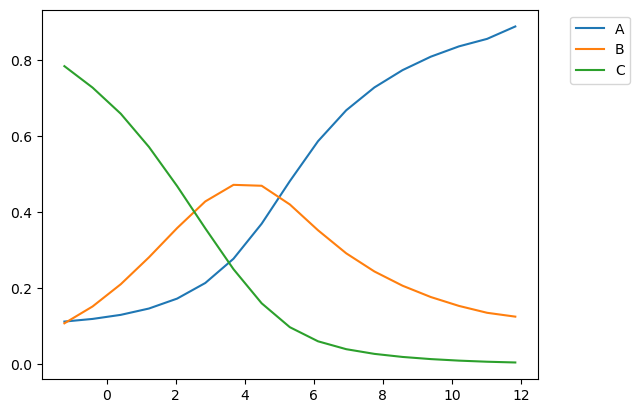

In [7]:
for species, profile in zip(species_list, jnp.exp(solns_b_old.T)):
    plt.plot(all_features, profile, label=f'{species}')
plt.legend(bbox_to_anchor=[1.2, 1], loc='upper right')

In [8]:
n=3
p=0.5
n_second_order=1
n_inputs=1
test=True
A=np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) #adjacency matrix
second_order_edge_idxs=np.array([[0, 1]])
F_a_idxs=np.array([[1, 2]])
E=np.array([0, 0, 0])
B=-1*jnp.log(np.array([1, 1, 10, 0.05, 0.1, 4]))
F=np.array([0, 0, 0])
seed=0
random_rxn_net_b=random_rxn_net(n, p, seed, n_second_order, n_inputs, test, A, second_order_edge_idxs, F_a_idxs)

In [ ]:
solns_new=[]
for F_a in all_features:
   sol_F_a=random_rxn_net_b.integrate(solver=Tsit5(), stepsize_controller=PIDController(0.5, 1), t_points=t_points, dt0=0.1, initial_conditions=initial_conditions, args=(E, B, F, F_a,), max_steps=10000) 
   solns_new.append(sol_F_a.ys[-1].copy())

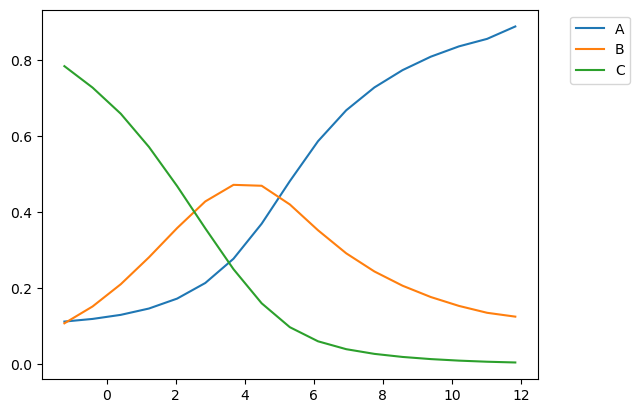

In [10]:
for species, profile in zip(species_list, jnp.exp(jnp.array(solns_new).T)):
    plt.plot(all_features, profile, label=f'{species}')
plt.legend(bbox_to_anchor=[1.2, 1], loc='upper right')

In [11]:
random_rxn_net_b.rxn_net_dynamics(1, initial_conditions, (E, B, F, 1,))

i: 0
i: 1
i: 2


Array([ 0.9       , -2.176661  ,  3.02776833], dtype=float64)

In [7]:
rxn_b_old.triangle_topology_b(1, initial_conditions, jnp.append(true_params, 1))

Array([ 0.9       , -2.176661  ,  3.02776833], dtype=float64)